In [29]:
import numpy as np
import pandas as pd
import random as random


In [31]:
# 1. Read the day/shift-level schedule from Roster_new.csv
df = pd.read_csv("roster_new.csv")
# df columns: [Tier, WeekendG, Positions, ShiftT, Day, Roster, ...]

# 2. Define how each ShiftT maps to the hours in a day
#    Example: 3 shifts of 8 hours each
def hours_in_shift(shiftT):
    if shiftT == 1:
        # Shift 1 covers hours 0..7 (which we’ll interpret as 1..8 in “human” form)
        return range(1, 13)
    elif shiftT == 2:
        # Shift 2 covers hours 8..15
        return range(5, 17)
    elif shiftT == 3:
        # Shift 3 covers hours 16..23
        return range(13, 25)
    else:
        # If there's some other logic, handle it here
        return []

# 3. Expand each shift row into multiple hourly rows
rows = []
for idx, row in df.iterrows():
    day_index   = row['Day']        # 1..42
    shift_index = row['ShiftT']     # 1..3
    positions   = row['Positions']  # e.g. "CNL"
    roster_val  = row['Roster']     # e.g. number of nurses assigned

    # For each hour in that shift, create a row
    for h in hours_in_shift(shift_index):
        # absolute hour: (day-1)*24 + h
        # +1 if you want your hour indexing to start at 1
        abs_hour = (day_index - 1)*24 + (h + 1)

        rows.append({
            'AbsHour': abs_hour,
            'Day': day_index,
            'Positions': positions,
            'AssignedNurses': roster_val
        })

df_hourly = pd.DataFrame(rows)

# 4. Group (or pivot) to see how many nurses per hour and position
df_grouped = df_hourly.groupby(['AbsHour','Day','Positions'], as_index=False)['AssignedNurses'].sum()

# 5. Add extra columns: Week, HourOfDay, HourOfWeek
df_grouped['Week'] = (df_grouped['AbsHour'] - 1)//168 + 1
df_grouped['HourOfDay'] = (df_grouped['AbsHour'] - 1)%24 + 1
df_grouped['HourOfWeek'] = (df_grouped['AbsHour'] - 1)%168 + 1

# 6. Write out the transformed schedule
df_grouped.to_csv("Roster_hourly.csv", index=False)

In [32]:
df_grouped

,AbsHour,Day,Positions,AssignedNurses,Week,HourOfDay,HourOfWeek
0,2,1,CNL,1,1,2,2
1,2,1,EDOU,2,1,2,2
2,2,1,FEP,1,1,2,2
3,2,1,blue,4,1,2,2
4,2,1,first nurse,1,1,2,2
...,...,...,...,...,...,...,...
13099,1009,42,orange,0,7,1,1
13100,1009,42,purple,4,7,1,1
13101,1009,42,red,3,7,1,1
13102,1009,42,resource nurse,1,7,1,1


In [33]:
df_hourly

,AbsHour,Day,Positions,AssignedNurses
0,2,1,CNL,0
1,3,1,CNL,0
2,4,1,CNL,0
3,5,1,CNL,0
4,6,1,CNL,0
...,...,...,...,...
353803,1005,42,hallway,0
353804,1006,42,hallway,0
353805,1007,42,hallway,0
353806,1008,42,hallway,0


In [34]:
import pandas as pd
import numpy as np

# Read the hourly roster CSV into a variable named roster_data
roster_data = pd.read_csv("Roster_hourly.csv")

# Create a DayOfWeek column (assuming Day 1 is Monday)
# (Day - 1) mod 7 gives 0 for Monday, 1 for Tuesday, ..., 6 for Sunday.
roster_data['DayOfWeek'] = (roster_data['Day'] - 1) % 7

# Map numeric day-of-week to day names (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
roster_data['DayName'] = roster_data['DayOfWeek'].map(day_mapping)

# Group by DayName and Positions and compute the average assigned nurses per hour.
average_data = roster_data.groupby(['DayName', 'Positions'])['AssignedNurses'].mean().reset_index()

# Floor the averages to integers
average_data['AssignedNurses'] = np.floor(average_data['AssignedNurses']).astype(int)

# Pivot the table so rows are days and columns are positions
pivot_data = average_data.pivot(index='DayName', columns='Positions', values='AssignedNurses')

# Reorder the rows to have days in order Monday -> Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = pivot_data.reindex(ordered_days)


# Display the resulting table


# Optionally, write out the resulting table to a CSV file
pivot_data.to_csv("Average_Nurses_by_Day.csv")

pivot_data

Positions,CNL,EDOU,FEP,blue,first nurse,green,hallway,iTrack,orange,purple,red,resource nurse,triage nurse
DayName,,,,,,,,,,,,,
Monday,1,2,1,2,1,3,3,0,4,3,3,1,1
Tuesday,1,2,1,3,1,3,3,0,3,3,3,1,1
Wednesday,1,2,1,4,1,3,4,0,3,3,2,1,1
Thursday,1,2,1,4,1,4,2,0,3,3,2,1,1
Friday,1,2,1,2,1,4,3,0,4,3,3,1,1
Saturday,1,2,1,4,1,4,3,0,2,3,2,1,1
Sunday,1,2,1,3,1,3,3,0,3,3,3,1,1


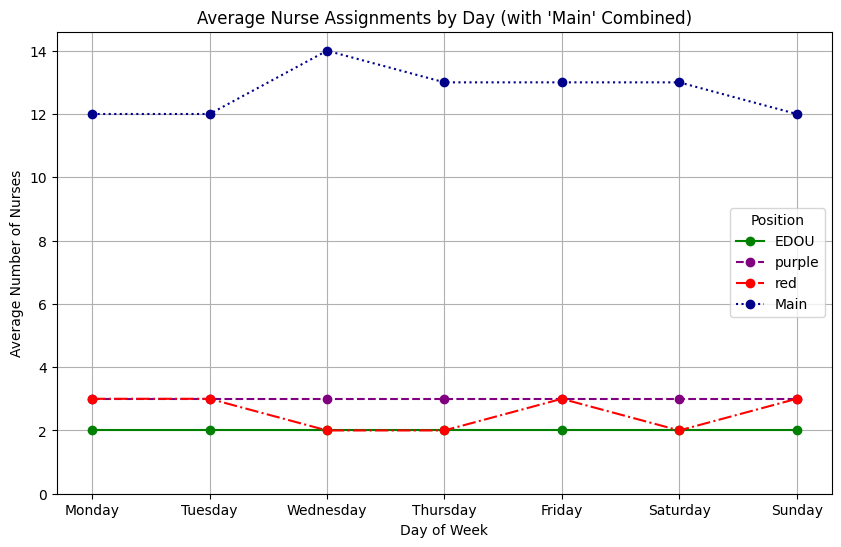

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# 1. Read the hourly roster CSV into a DataFrame
roster_data = pd.read_csv("Roster_hourly.csv")

# 2. Create a DayOfWeek column (assuming Day 1 is Monday)
roster_data['DayOfWeek'] = (roster_data['Day'] - 1) % 7

# Map numeric day-of-week to day names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
roster_data['DayName'] = roster_data['DayOfWeek'].map(day_mapping)

# 3. Group by DayName and Positions and compute the average assigned nurses per hour
avg_data = roster_data.groupby(['DayName', 'Positions'])['AssignedNurses'].mean().reset_index()

# Floor the averages to integers
avg_data['AssignedNurses'] = np.floor(avg_data['AssignedNurses']).astype(int)

# 4. Pivot the table so rows are days and columns are positions
pivot_table = avg_data.pivot(index='DayName', columns='Positions', values='AssignedNurses')

# Reorder the rows to have days in order Monday -> Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(ordered_days)

# 5. Combine the columns for "green", "orange", "blue", "hallway", and "iTrack" into one column "Main"
main_cols = ['green', 'orange', 'blue', 'hallway', 'iTrack']
existing_main_cols = [col for col in main_cols if col in pivot_table.columns]
pivot_table['Main'] = pivot_table[existing_main_cols].sum(axis=1)

# 6. Exclude unwanted positions:
# The 5 positions to exclude are: CNL, FEP, first nurse, resource nurse, triage nurse.
exclude_positions = ['CNL', 'FEP', 'first nurse', 'resource nurse', 'triage nurse']
# Also remove the individual main columns (since we want only the combined "Main")
cols_to_exclude = exclude_positions + main_cols

# Keep only the columns not in the exclusion list
cols_to_keep = [col for col in pivot_table.columns if col not in cols_to_exclude]
if 'Main' not in cols_to_keep:
    cols_to_keep.append('Main')

final_table = pivot_table[cols_to_keep]

# 7. Customize line colors and styles and plot the data
plt.figure(figsize=(10,6))

# Define your custom colors and line styles (adjust as desired)
custom_colors = ['green', 'purple', 'red', 'darkblue']
custom_line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1))]

# Create cycles for colors and line styles
color_cycle = itertools.cycle(custom_colors)
line_style_cycle = itertools.cycle(custom_line_styles)

for col in final_table.columns:
    clr = next(color_cycle)
    ls = next(line_style_cycle)
    plt.plot(final_table.index, final_table[col], marker='o',
             label=col, color=clr, linestyle=ls)

plt.xlabel("Day of Week")
plt.ylabel("Average Number of Nurses")
plt.title("Average Nurse Assignments by Day (with 'Main' Combined)")
plt.legend(title="Position")
plt.ylim(bottom=0)  # Force the y-axis to start at 0
plt.grid(True)

plt.savefig("average_week_plot.png", dpi=300, bbox_inches='tight')

plt.show()


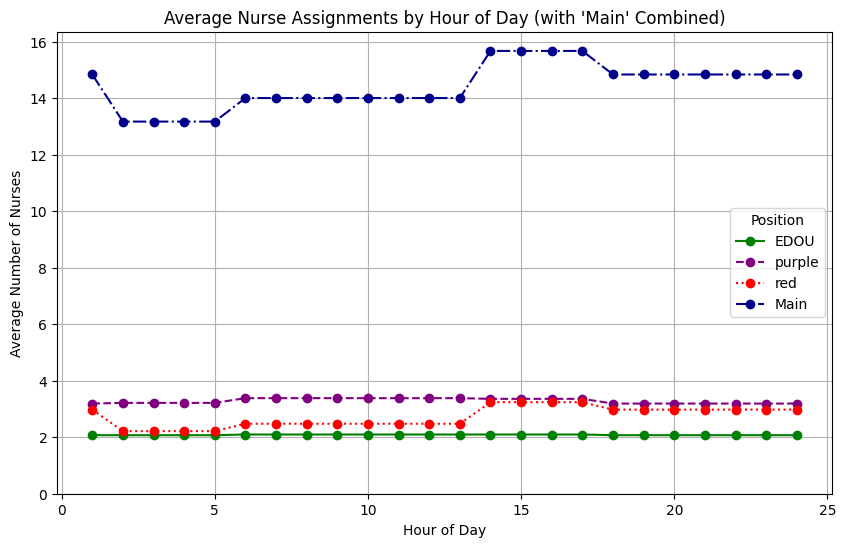

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Read the hourly roster CSV into a DataFrame
roster_data = pd.read_csv("Roster_hourly.csv")

# Ensure HourOfDay is present; if not, compute it from AbsHour
if 'HourOfDay' not in roster_data.columns:
    roster_data['HourOfDay'] = ((roster_data['AbsHour'] - 1) % 24) + 1

# Group by HourOfDay and Positions and compute the average assigned nurses per hour
avg_hourly = roster_data.groupby(['HourOfDay', 'Positions'])['AssignedNurses'].mean().reset_index()

# Pivot the table so that rows are HourOfDay and columns are Positions
pivot_hourly = avg_hourly.pivot(index='HourOfDay', columns='Positions', values='AssignedNurses')
pivot_hourly = pivot_hourly.sort_index()

# Combine the columns for "green", "orange", "blue", "hallway", and "itrack" into one column "Main"
main_cols = ['green', 'orange', 'blue', 'hallway', 'iTrack']
existing_main_cols = [col for col in main_cols if col in pivot_hourly.columns]
pivot_hourly['Main'] = pivot_hourly[existing_main_cols].sum(axis=1)

# Exclude unwanted positions:
# The positions to exclude are: CNL, FEP, first nurse, resource nurse, triage nurse.
exclude_positions = ['CNL', 'FEP', 'first nurse', 'resource nurse', 'triage nurse']
# Also remove the individual main columns since we want only the combined "Main"
cols_to_exclude = exclude_positions + main_cols

# Keep only the columns not in the exclusion list
cols_to_keep = [col for col in pivot_hourly.columns if col not in cols_to_exclude]
if 'Main' not in cols_to_keep:
    cols_to_keep.append('Main')

final_hourly = pivot_hourly[cols_to_keep]

# Plot the data: one line per remaining position with different line styles
plt.figure(figsize=(10, 6))

# Define a list of different line styles and custom colors, then cycle through them
line_styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1)), (0, (1, 1))]
colors = ['green', 'purple', 'red', 'darkblue']  # Customize colors as desired

style_cycle = itertools.cycle(line_styles)
color_cycle = itertools.cycle(colors)

for col in final_hourly.columns:
    ls = next(style_cycle)
    clr = next(color_cycle)
    plt.plot(final_hourly.index, final_hourly[col],
             linestyle=ls, marker='o', label=col, color=clr)

plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Nurses")
plt.title("Average Nurse Assignments by Hour of Day (with 'Main' Combined)")
plt.legend(title="Position")
plt.grid(True)
plt.ylim(bottom=0)  # Force the y-axis to start at 0

plt.savefig("24-hour_plot.png", dpi=300, bbox_inches='tight')

plt.show()
